IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import norm
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

LOAD DATASET

In [2]:
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test.head(2)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


DATA EXPLORATION

In [4]:
#helpful info about test 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [5]:
#helpful info about train 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
#useful summary statistics
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [7]:
#useful summary statistics
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


ANALYZE TEST VARIABLE

In [8]:
#saleprice is our test variable
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



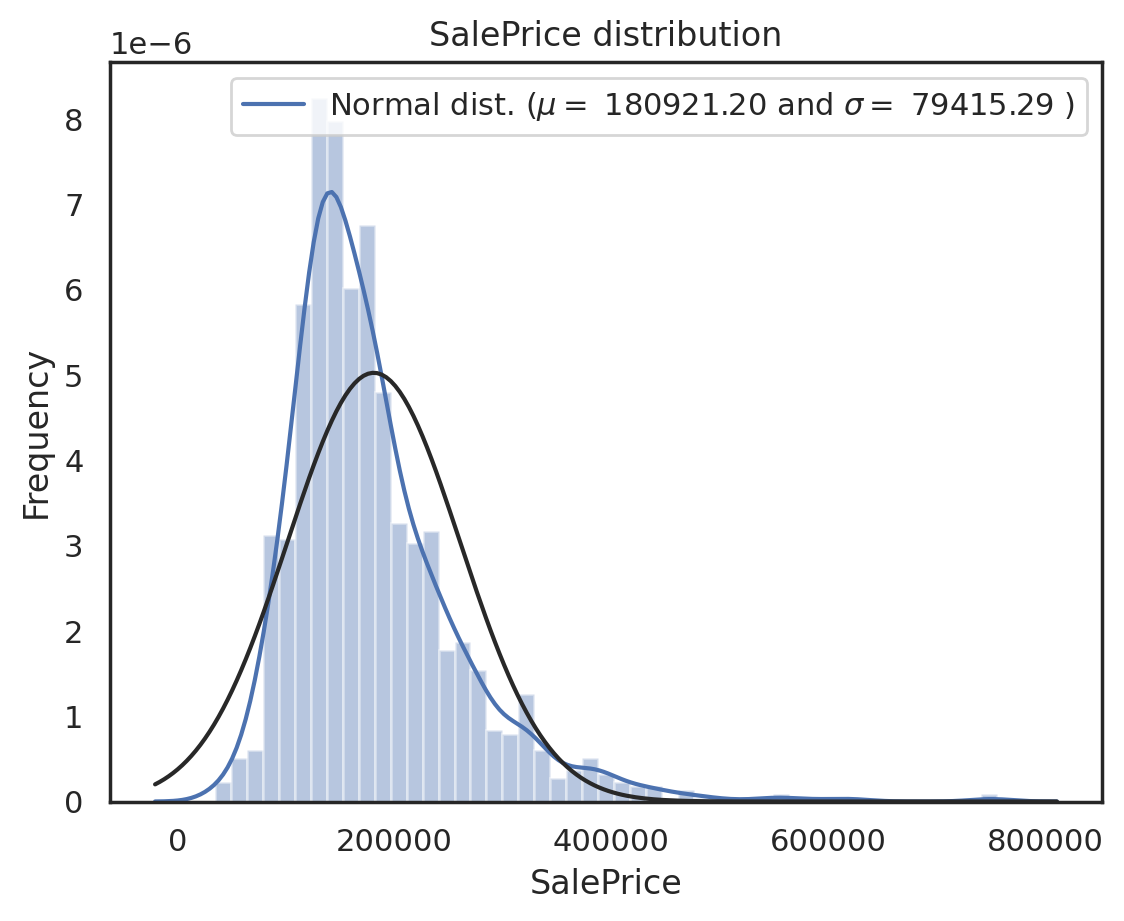

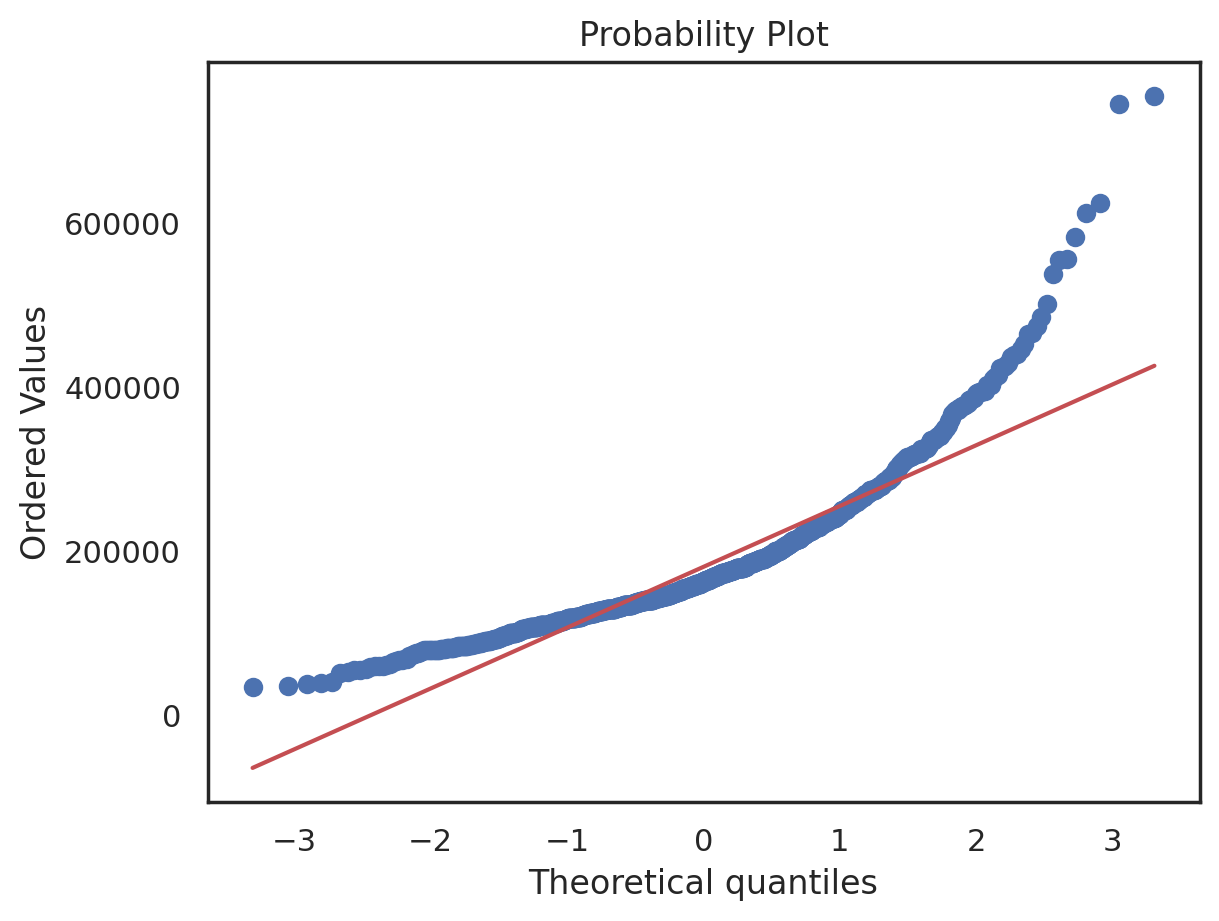

Skewness: 1.882876
Kurtosis: 6.536282


In [9]:
# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Need to fix so that sale prices don't deviate from the normal distribution.

In [10]:
#pull Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [11]:
#pull Categorical Data
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
#Count categorical and numerical features
cat_features = train.select_dtypes(include=['object']).shape[1]
num_features = train.select_dtypes(include=['int64', 'float64']).shape[1]

print(f'Total Features: {cat_features} categorical + {num_features} numerical = {cat_features + num_features} features')

Total Features: 43 categorical + 38 numerical = 81 features


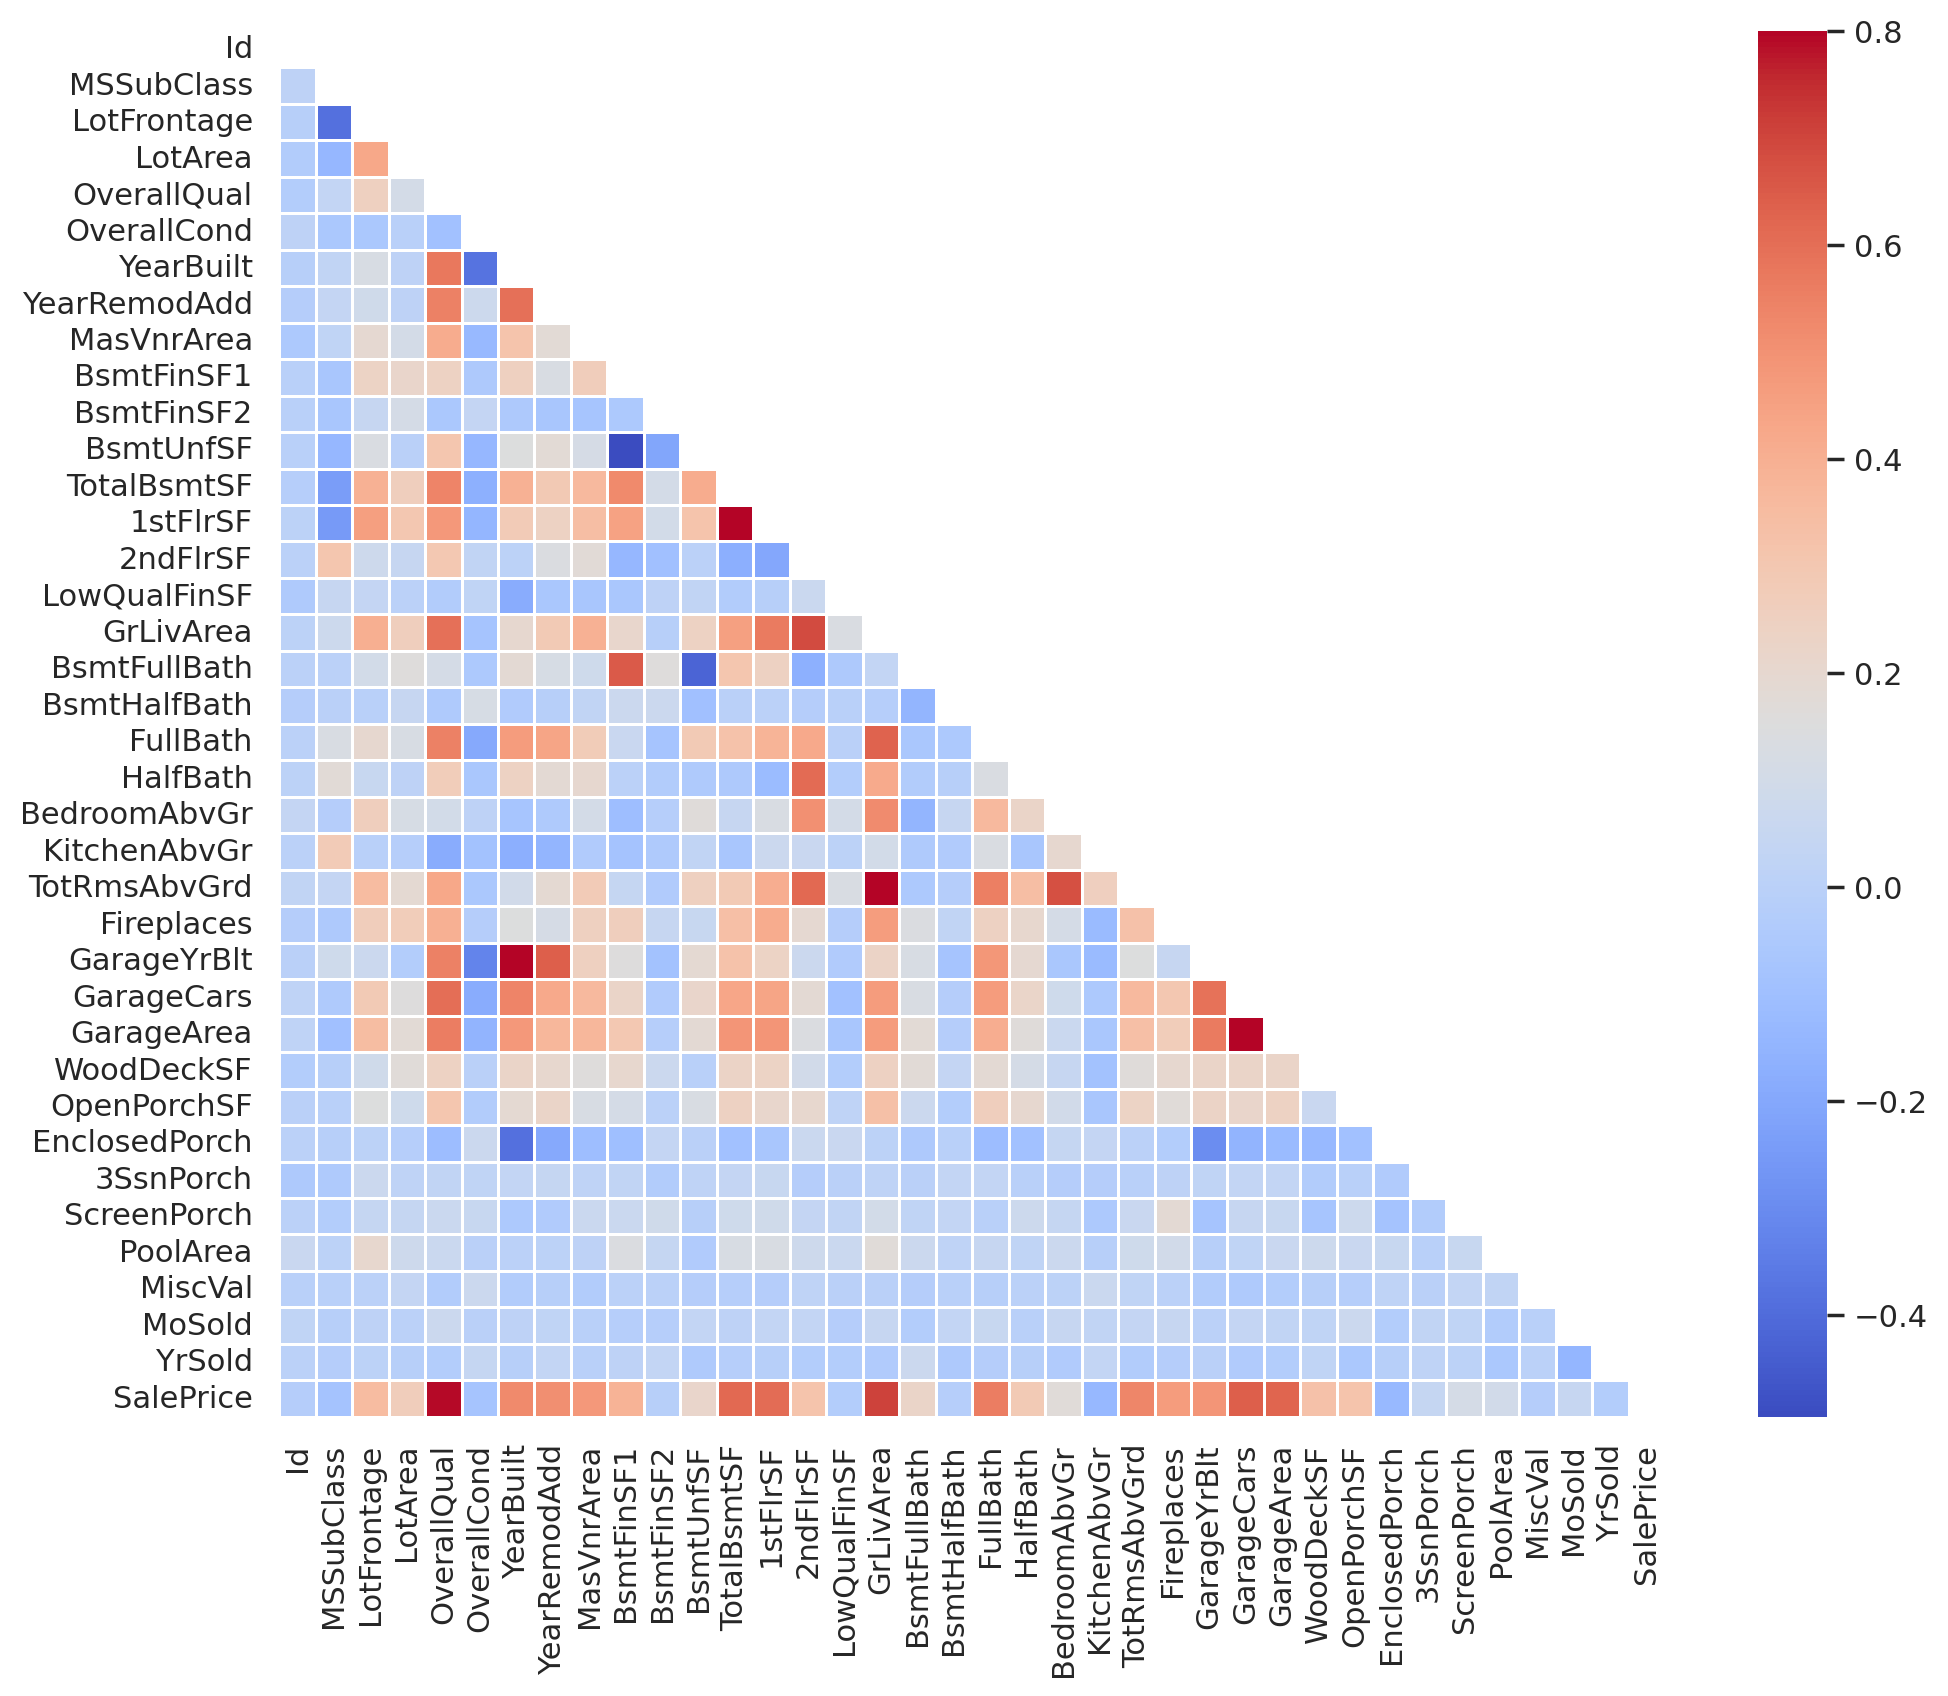

In [13]:
# Calculate the correlation matrix, better understand correlated features
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, vmax=0.8, square=True, linewidths=0.5)
plt.show()

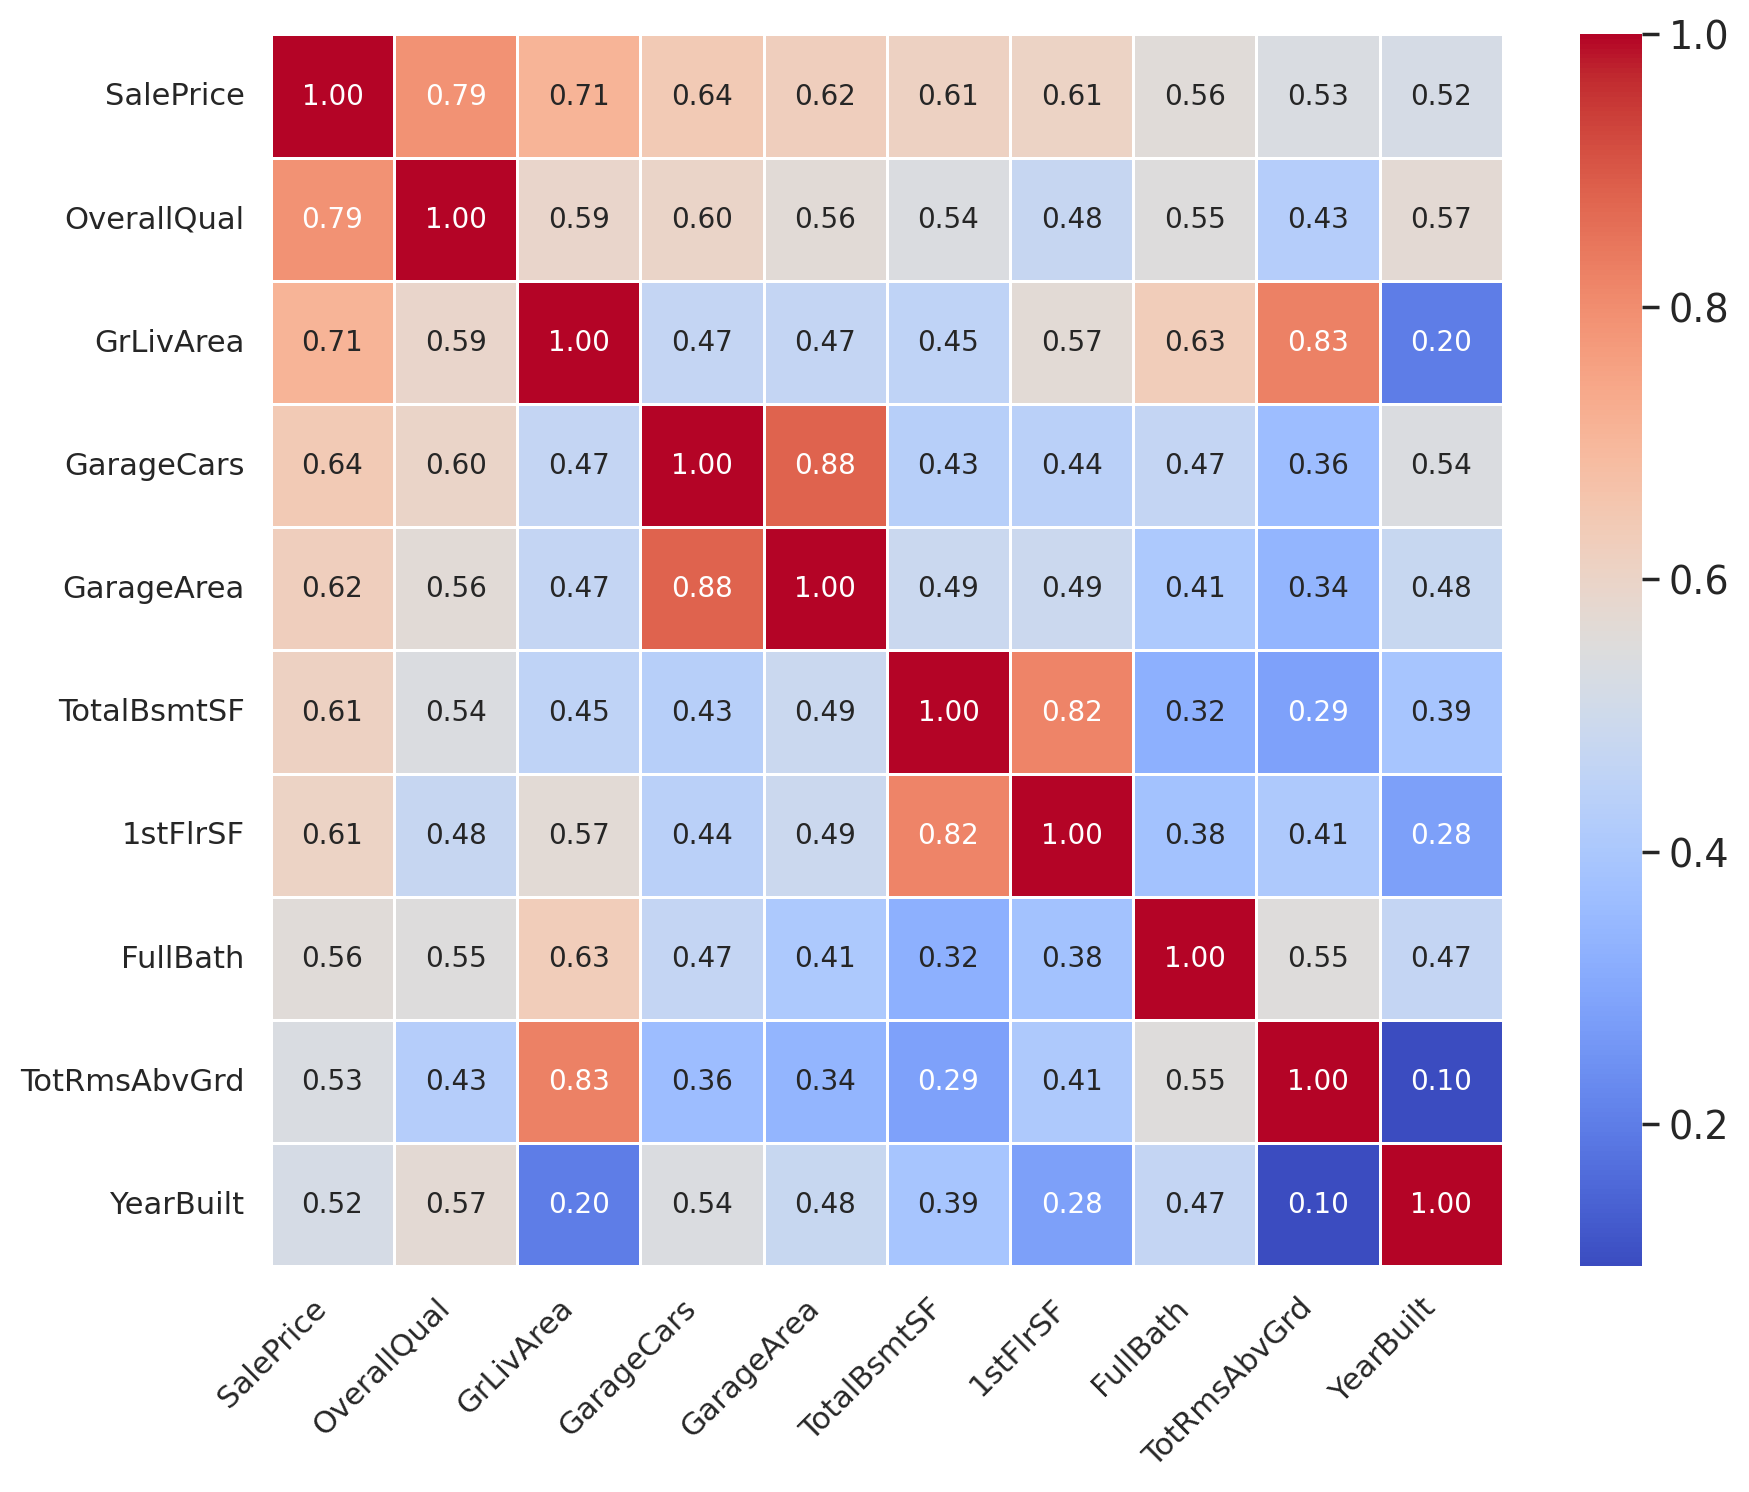

In [14]:
#Display top 10 correlated features
k = 10
top_k_corr = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
correlation_matrix_top_k = train[top_k_corr].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.25, style="white")
heatmap = sns.heatmap(correlation_matrix_top_k, cmap='coolwarm', annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, linewidths=0.5)
heatmap.set_xticklabels(top_k_corr.values, rotation=45, ha='right')
heatmap.set_yticklabels(top_k_corr.values)
plt.show()

In [15]:
numeric_cols = train.select_dtypes(include=[np.number])
correlation = numeric_cols.corr()

# Find the top 10 most correlated features with 'SalePrice'
top_10_corr = correlation['SalePrice'].sort_values(ascending=False)[:10]

# Find the 5 most uncorrelated features with 'SalePrice'
bottom_5_corr = correlation['SalePrice'].sort_values(ascending=True)[:5]

print("The Most Correlated Features with SalePrice:")
print(top_10_corr, '\n')
print("The Most Uncorrelated Features with SalePrice:")
print(bottom_5_corr)

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
Name: SalePrice, dtype: float64


Most correlated features to sale price: Overall quality score (79%), above-ground living area (71%), garage area (64%), number-of-car garage (62%).

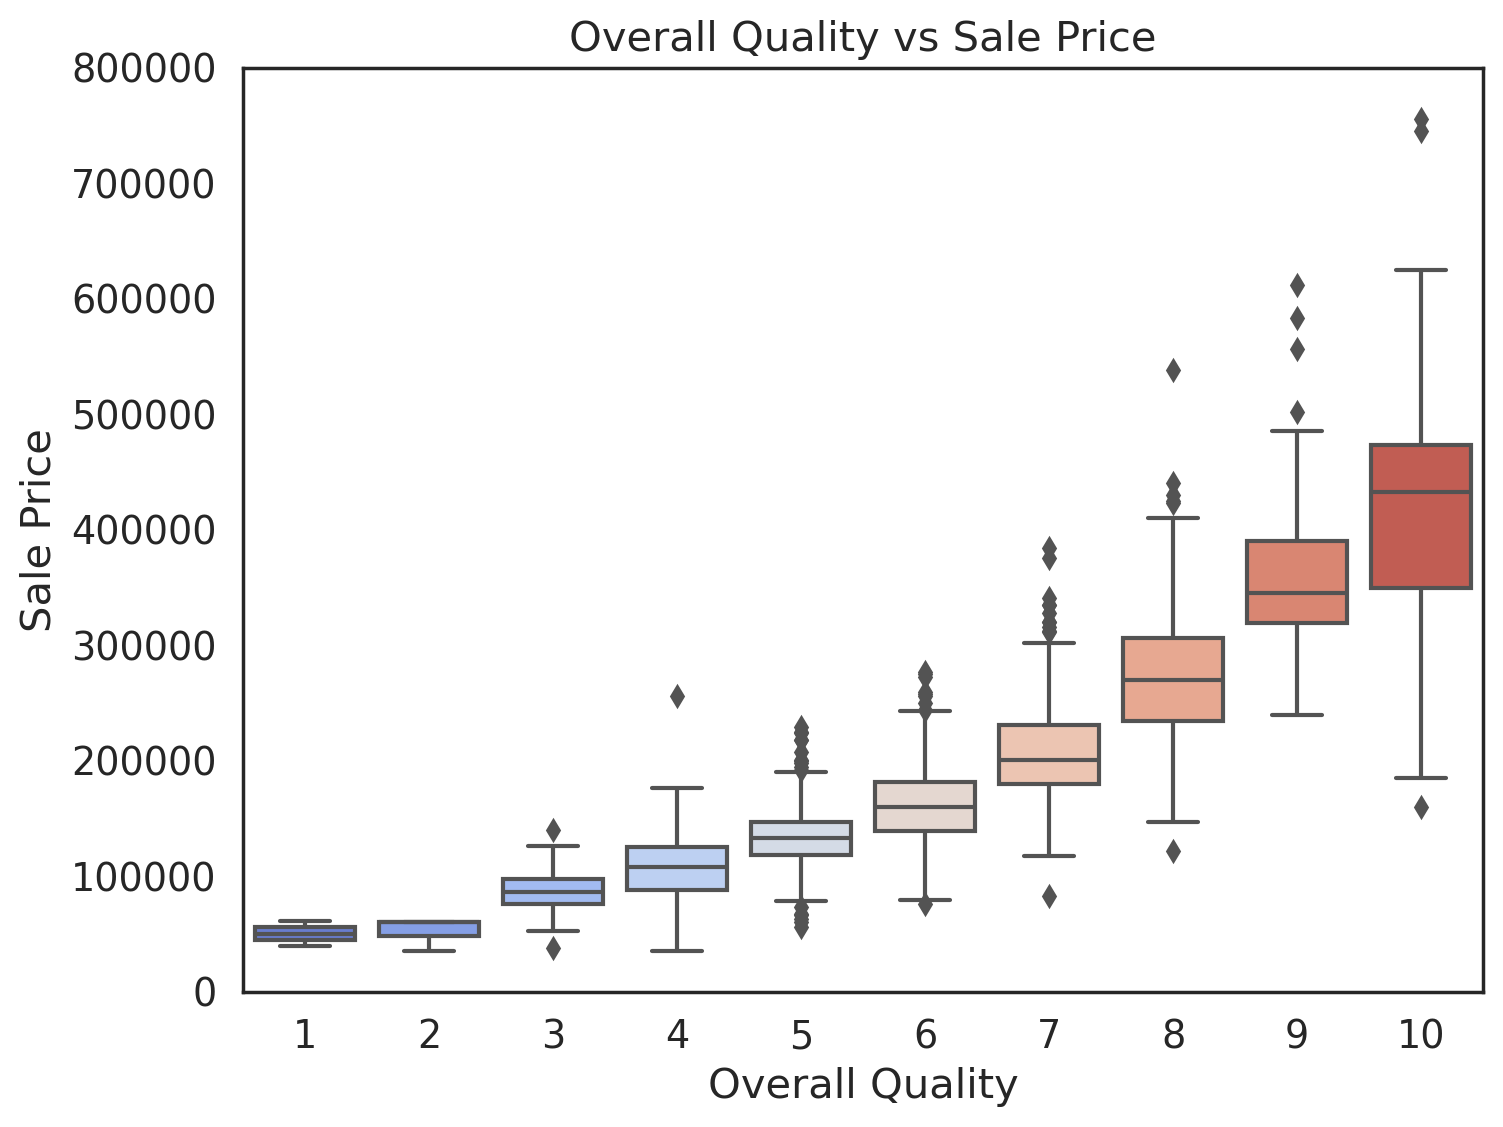

In [16]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=var, y='SalePrice', data=data, width=0.8, palette="coolwarm")
ax.set_ylim(0, 800000)
ax.set_xlabel('Overall Quality')
ax.set_ylabel('Sale Price')
ax.set_title('Overall Quality vs Sale Price')
plt.show()

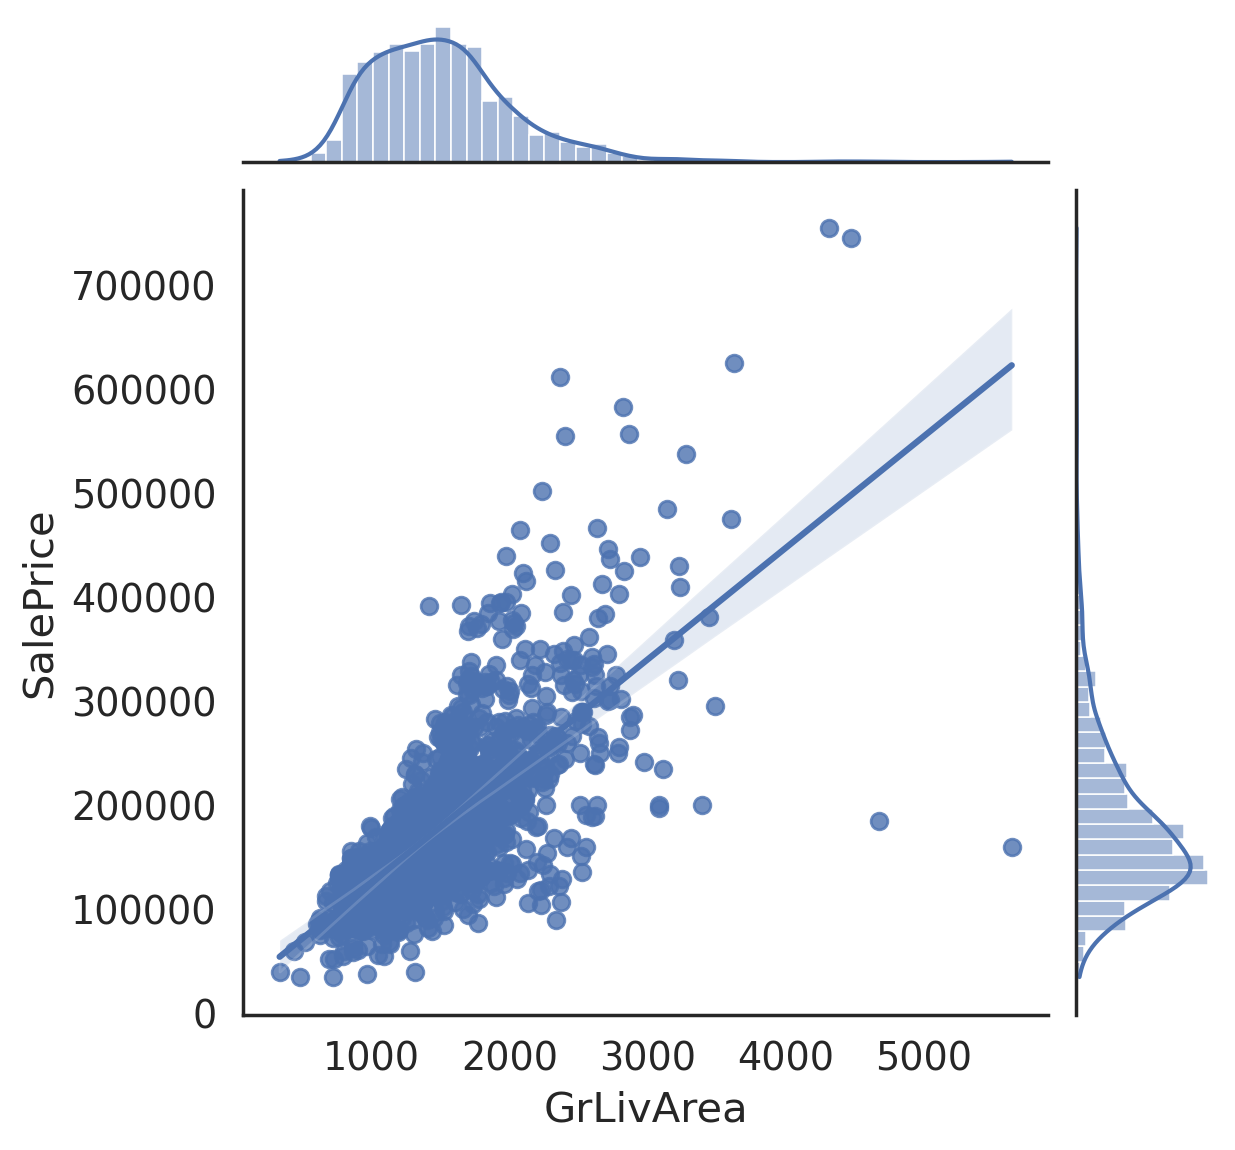

In [17]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Contains outliers that we need to remove

In [18]:
#Removing outliers manually
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

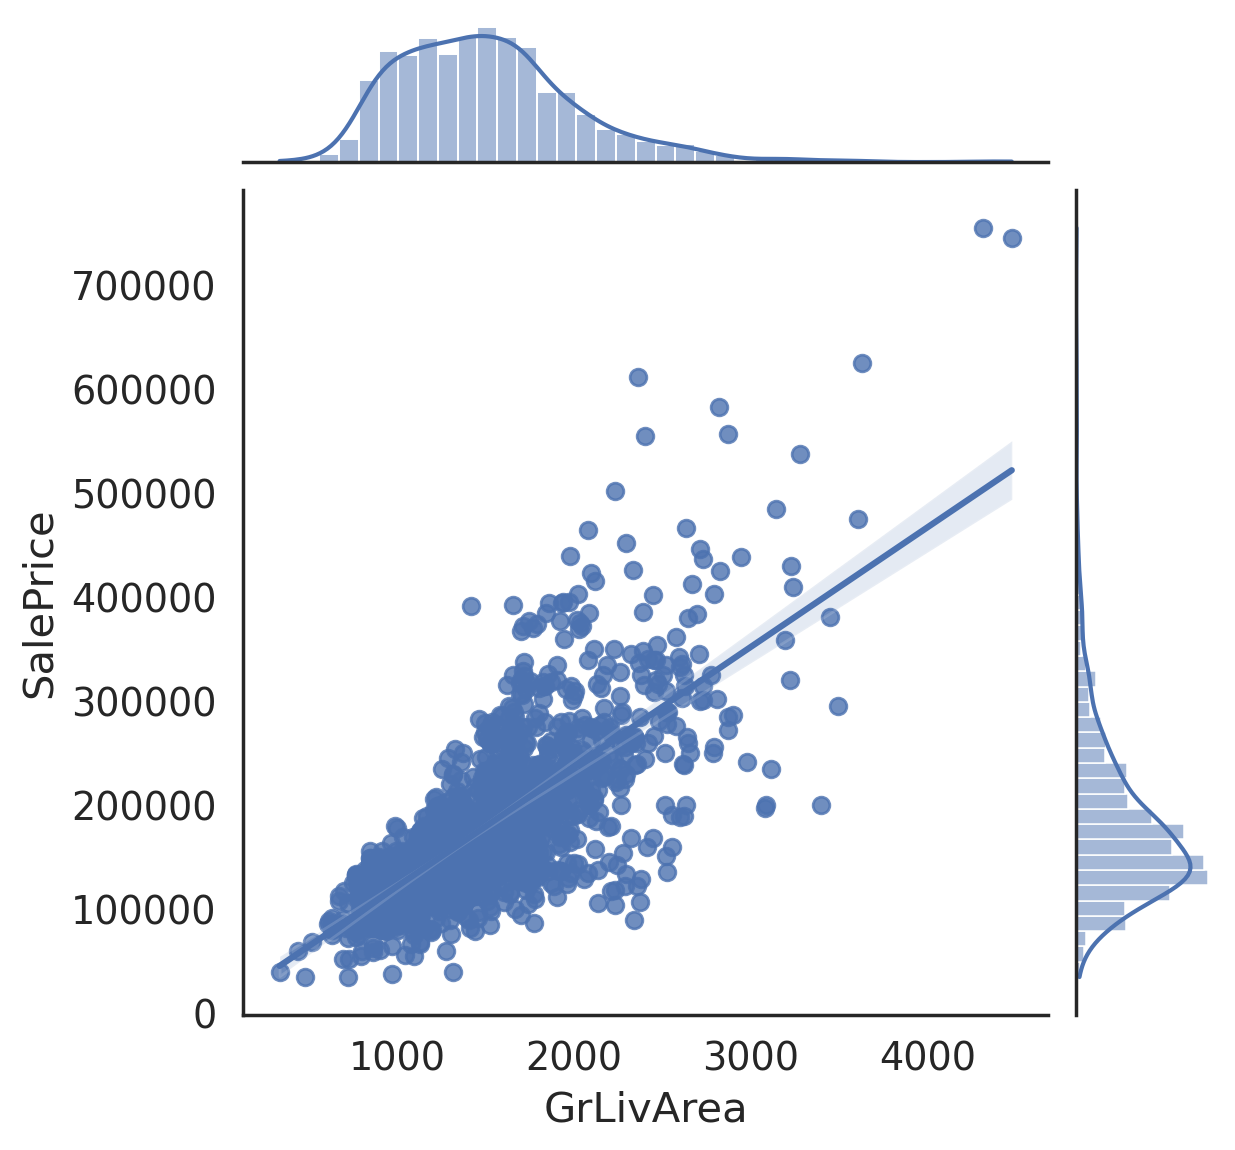

In [19]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Contains no outliers

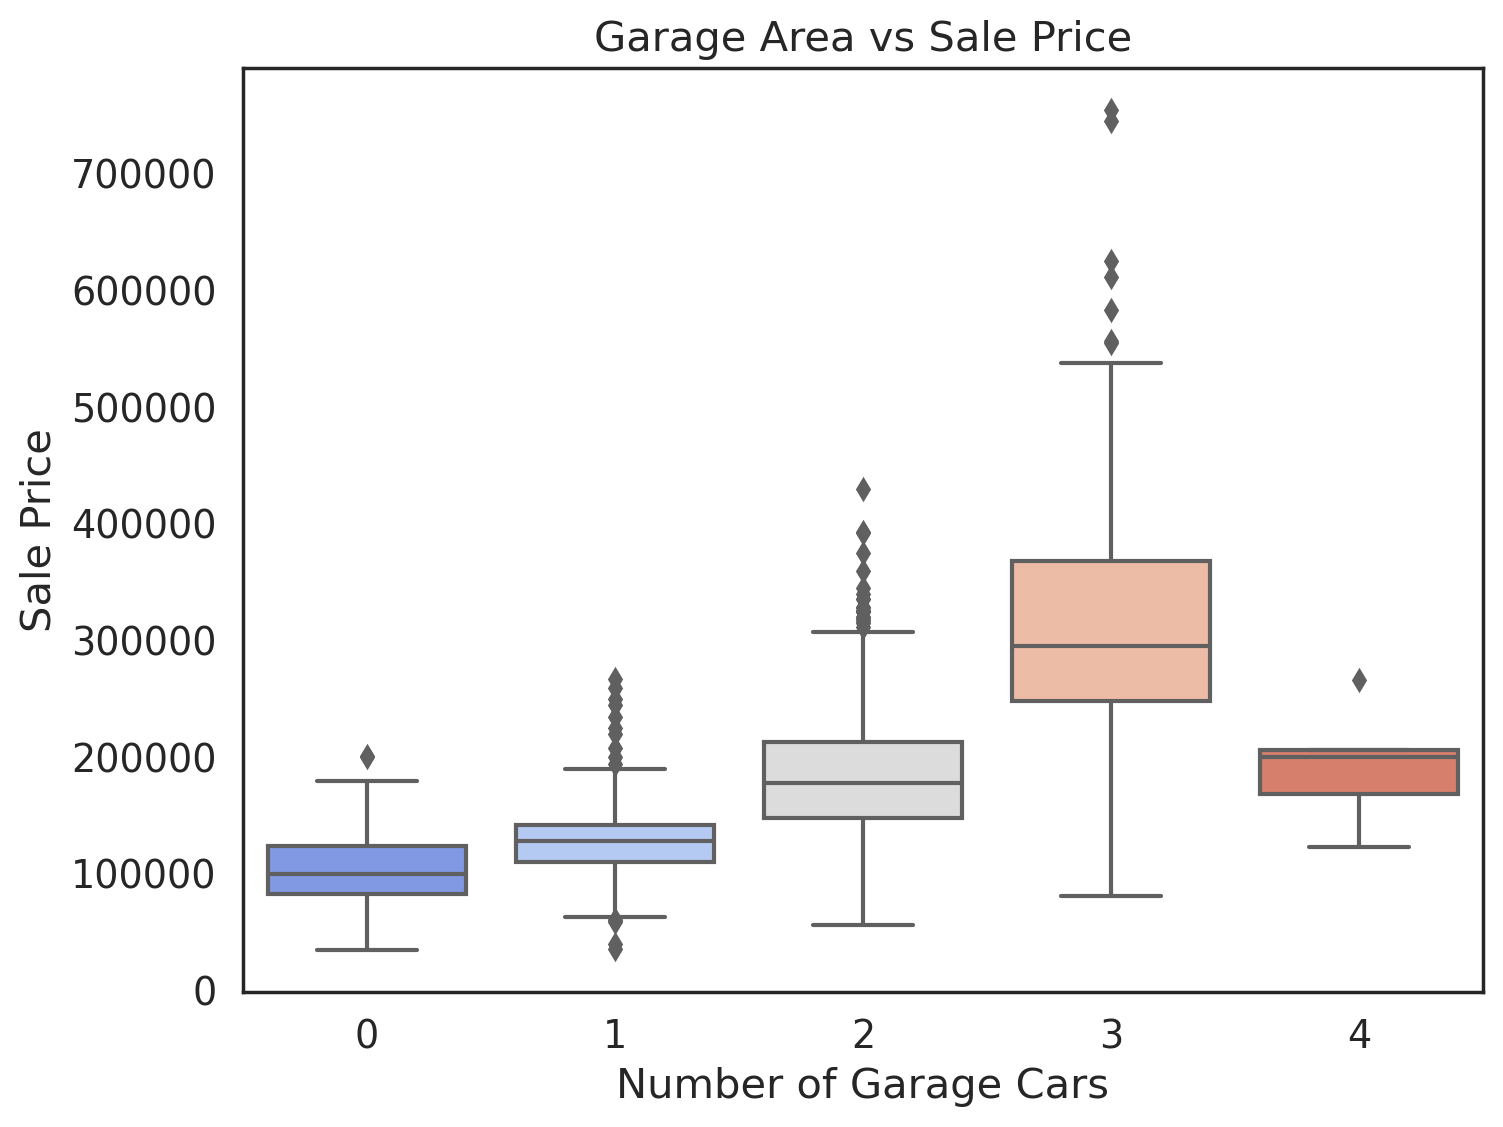

In [20]:
# Garage Area vs Sale Price
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train, width=0.8, palette="coolwarm")
ax.set_xlabel('Number of Garage Cars')
ax.set_ylabel('Sale Price')
ax.set_title('Garage Area vs Sale Price')
plt.show()

In [21]:
# Removing outliers
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

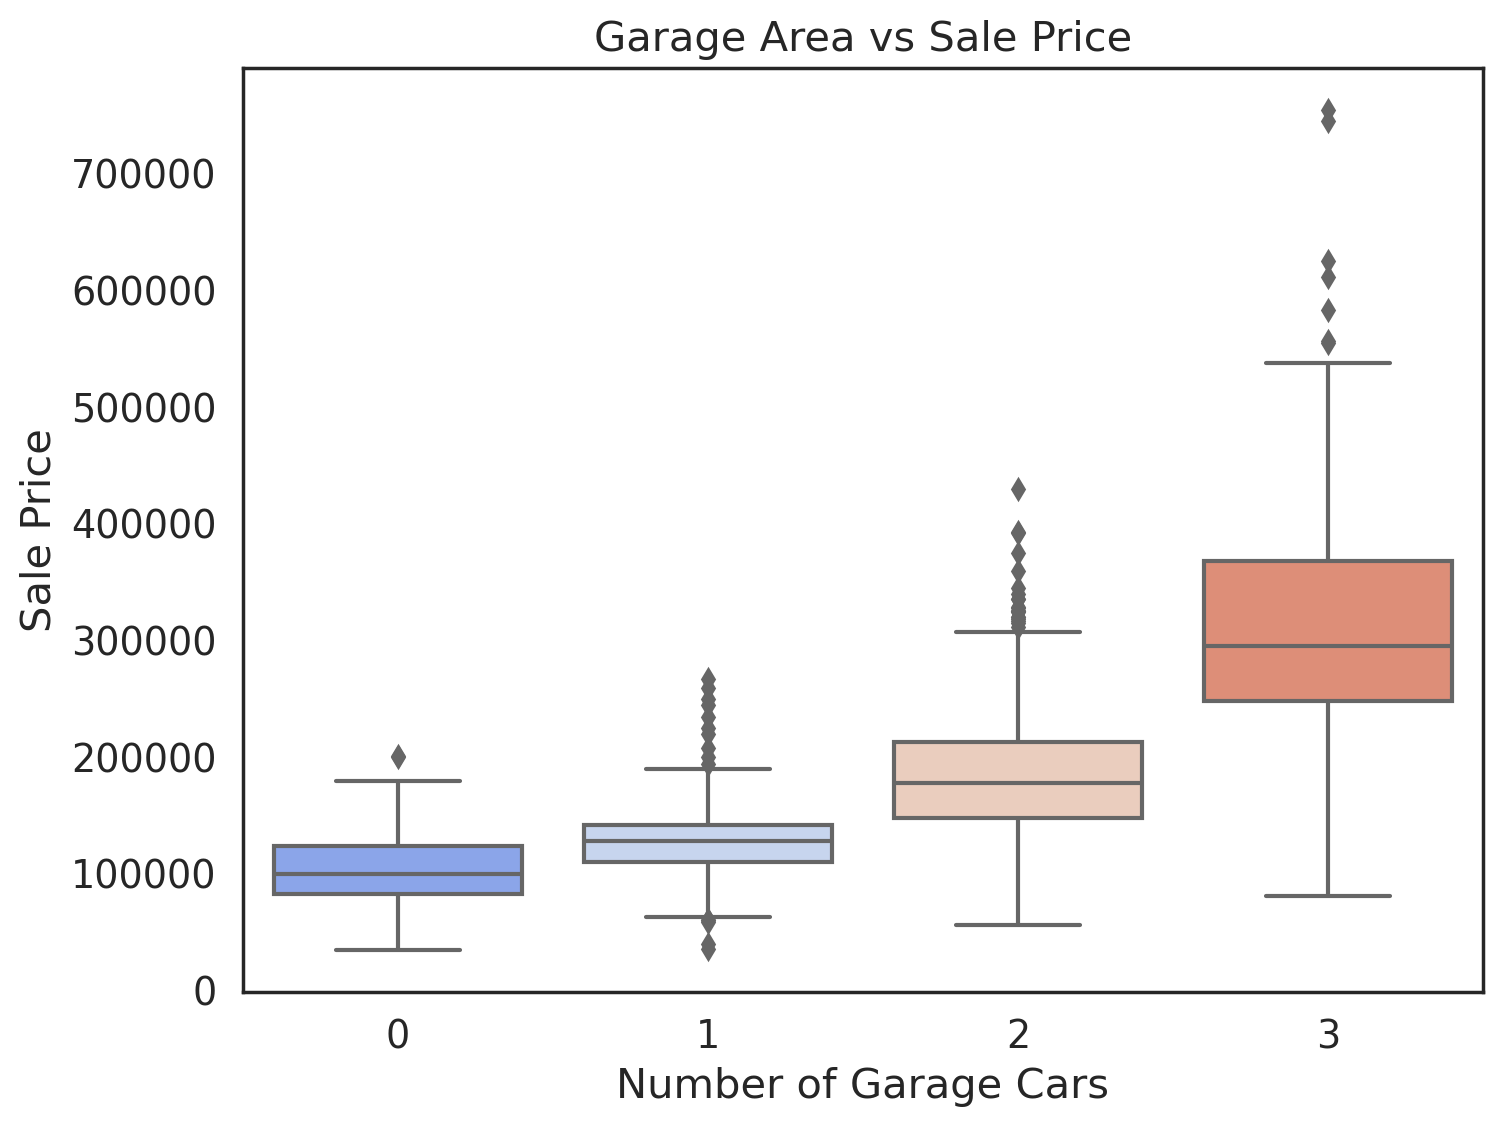

In [22]:
# Garage Area vs Sale Price
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train, width=0.8, palette="coolwarm")
ax.set_xlabel('Number of Garage Cars')
ax.set_ylabel('Sale Price')
ax.set_title('Garage Area vs Sale Price')
plt.show()

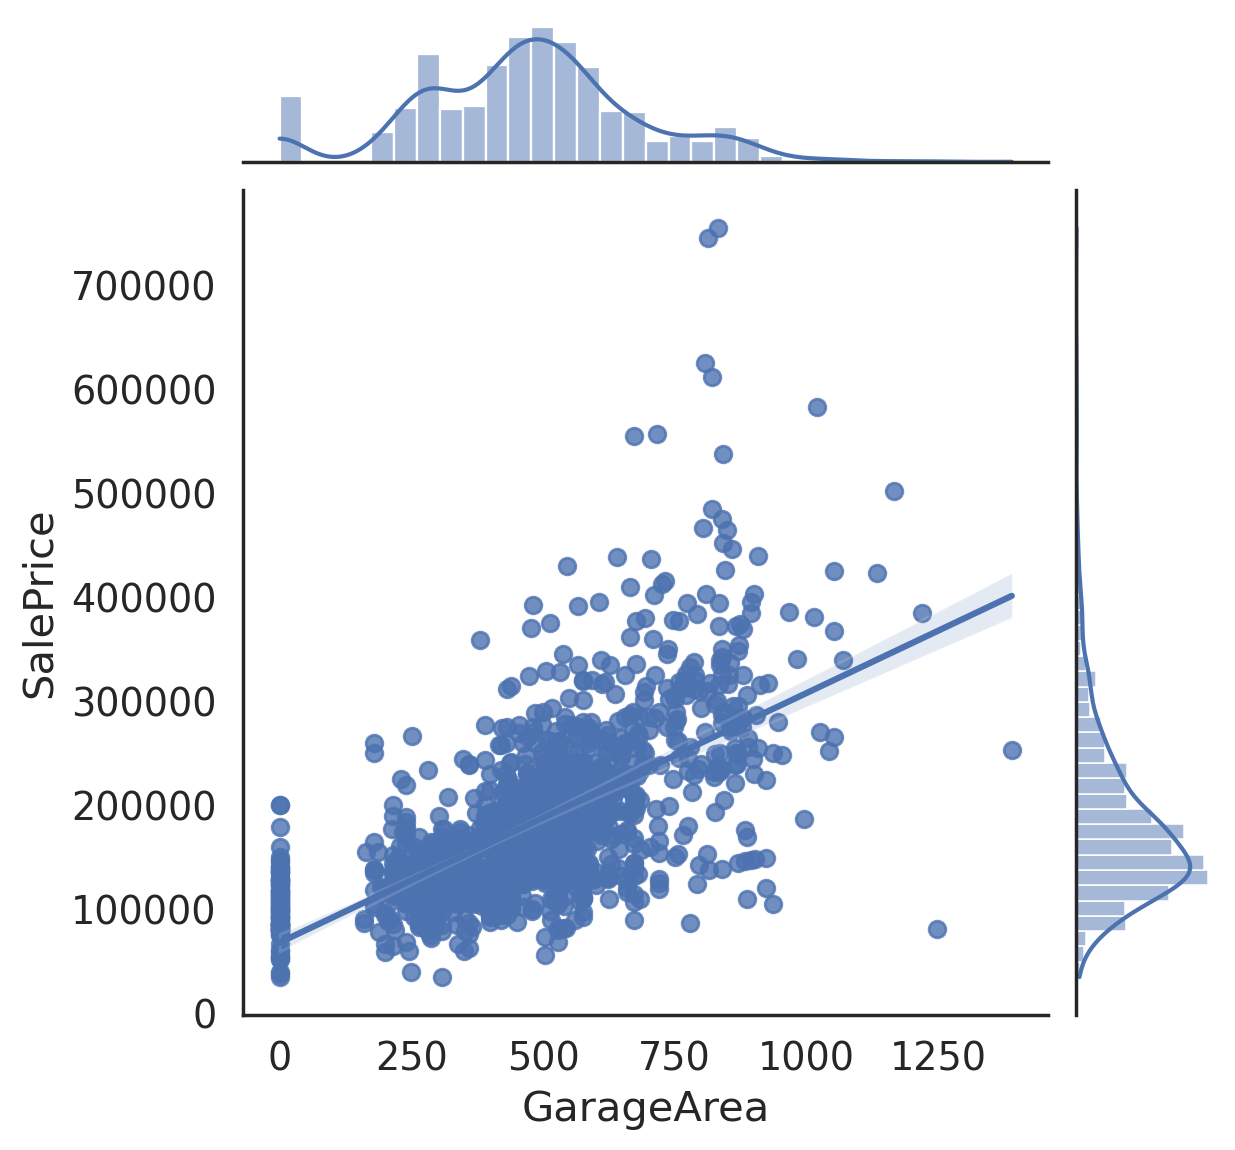

In [23]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

Contains outliers

In [24]:
# Removing outliers
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

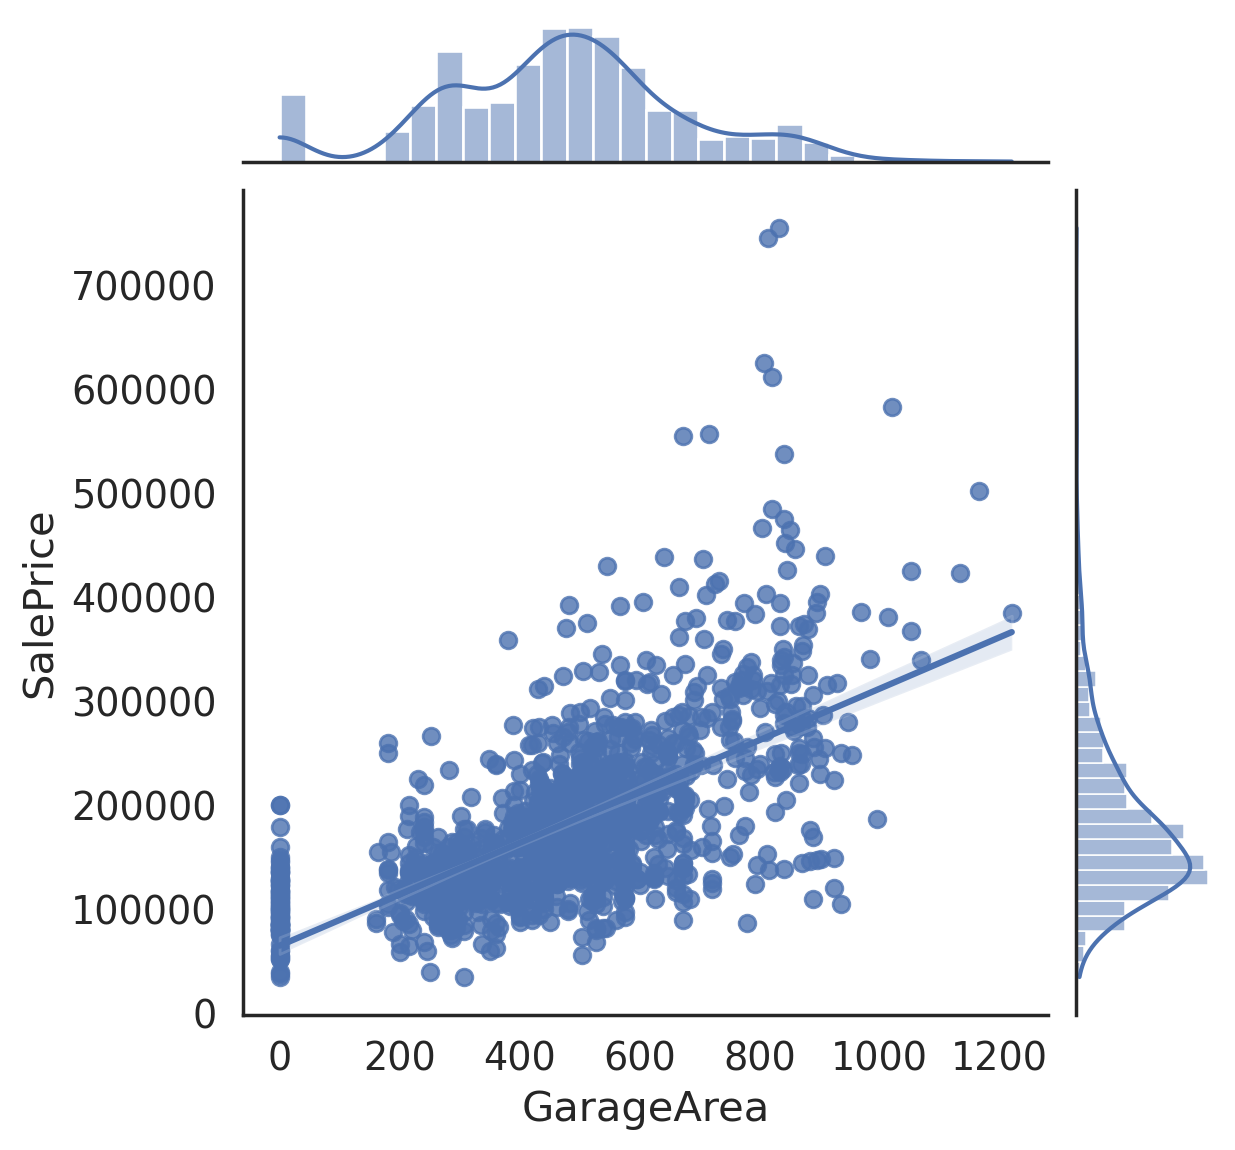

In [25]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

No outliers

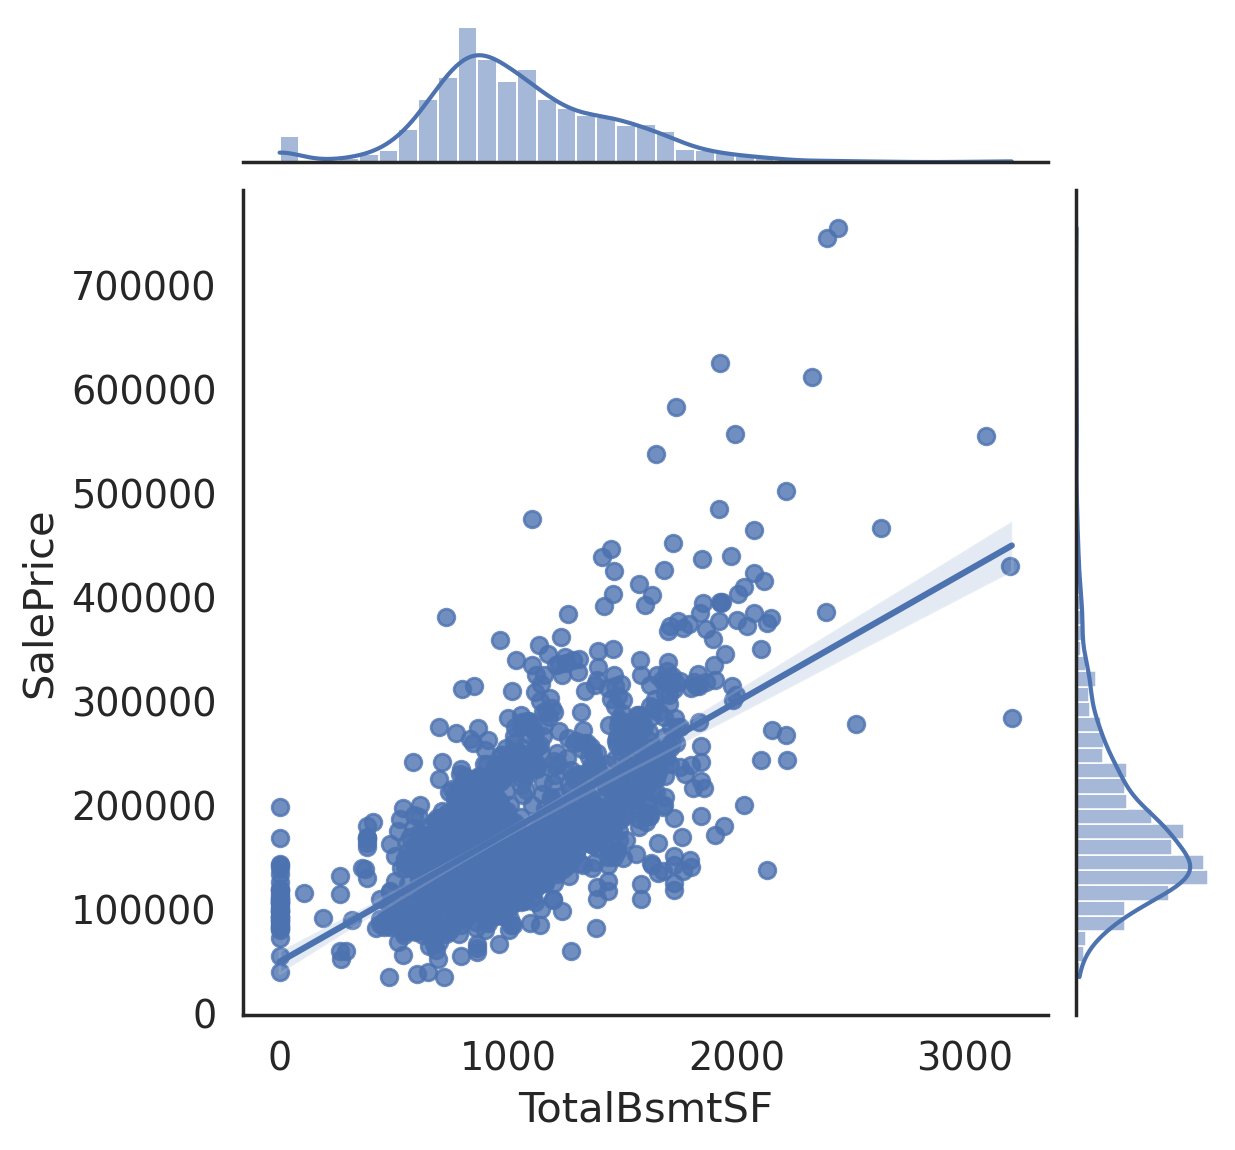

In [26]:
# Basement Area vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

No outliers

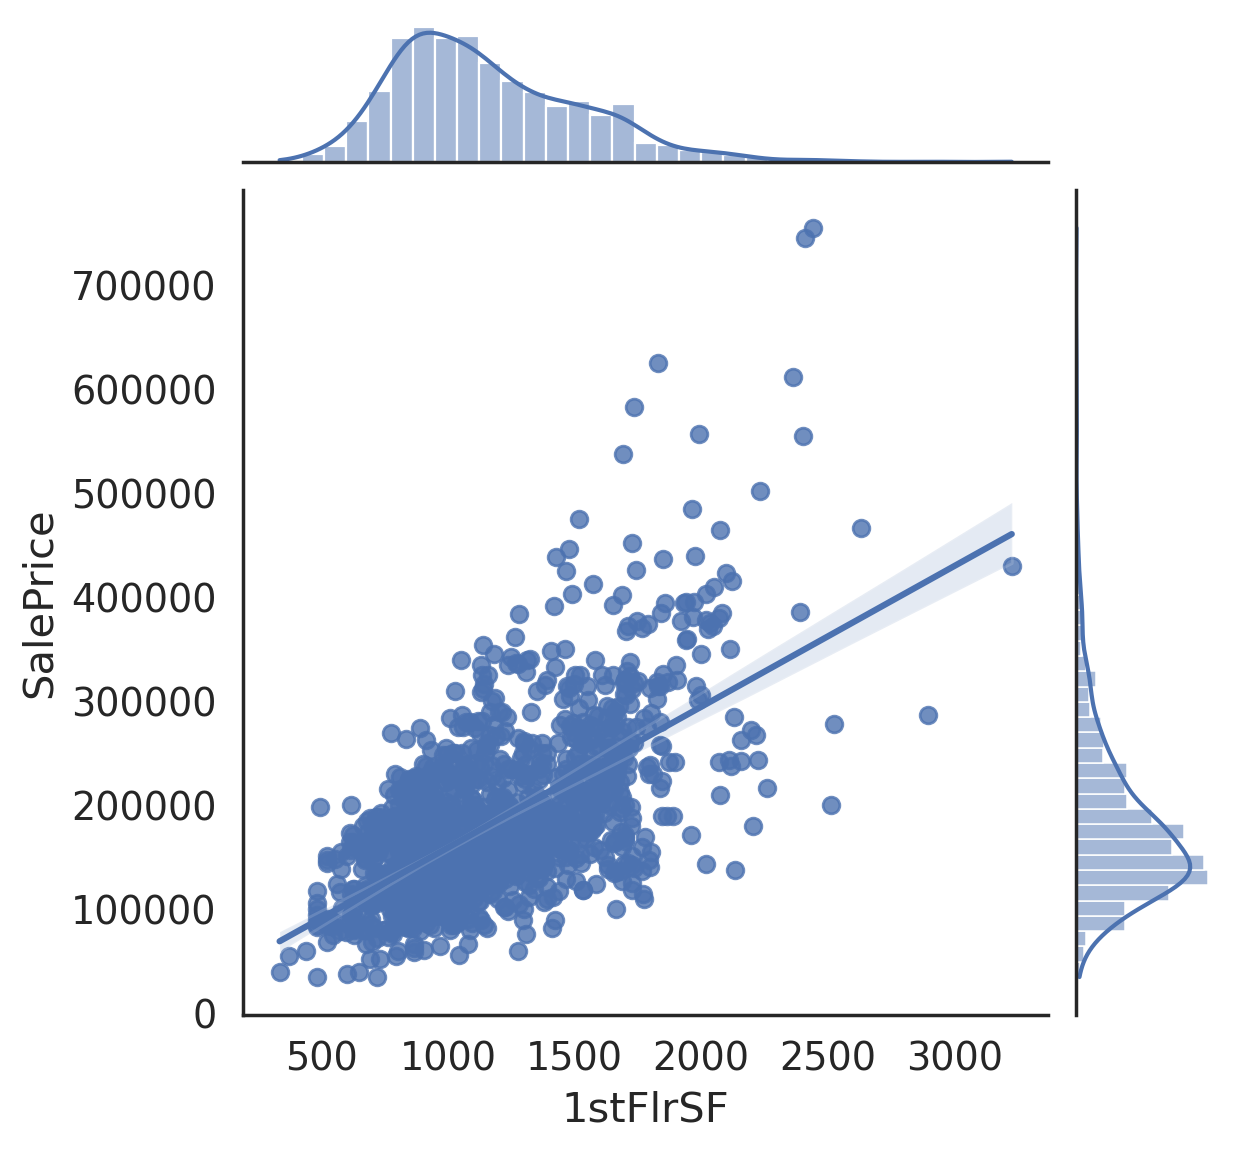

In [27]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

No outliers

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

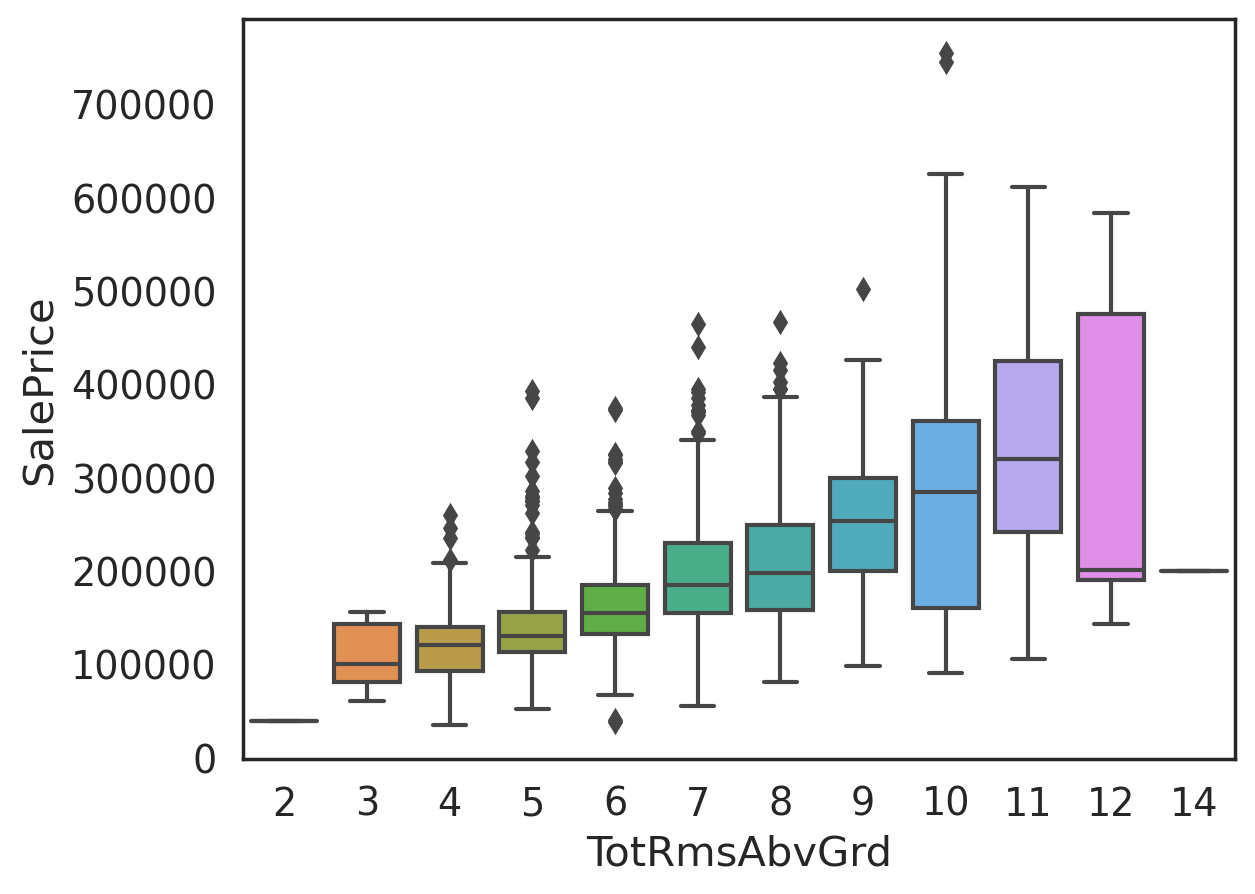

In [28]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

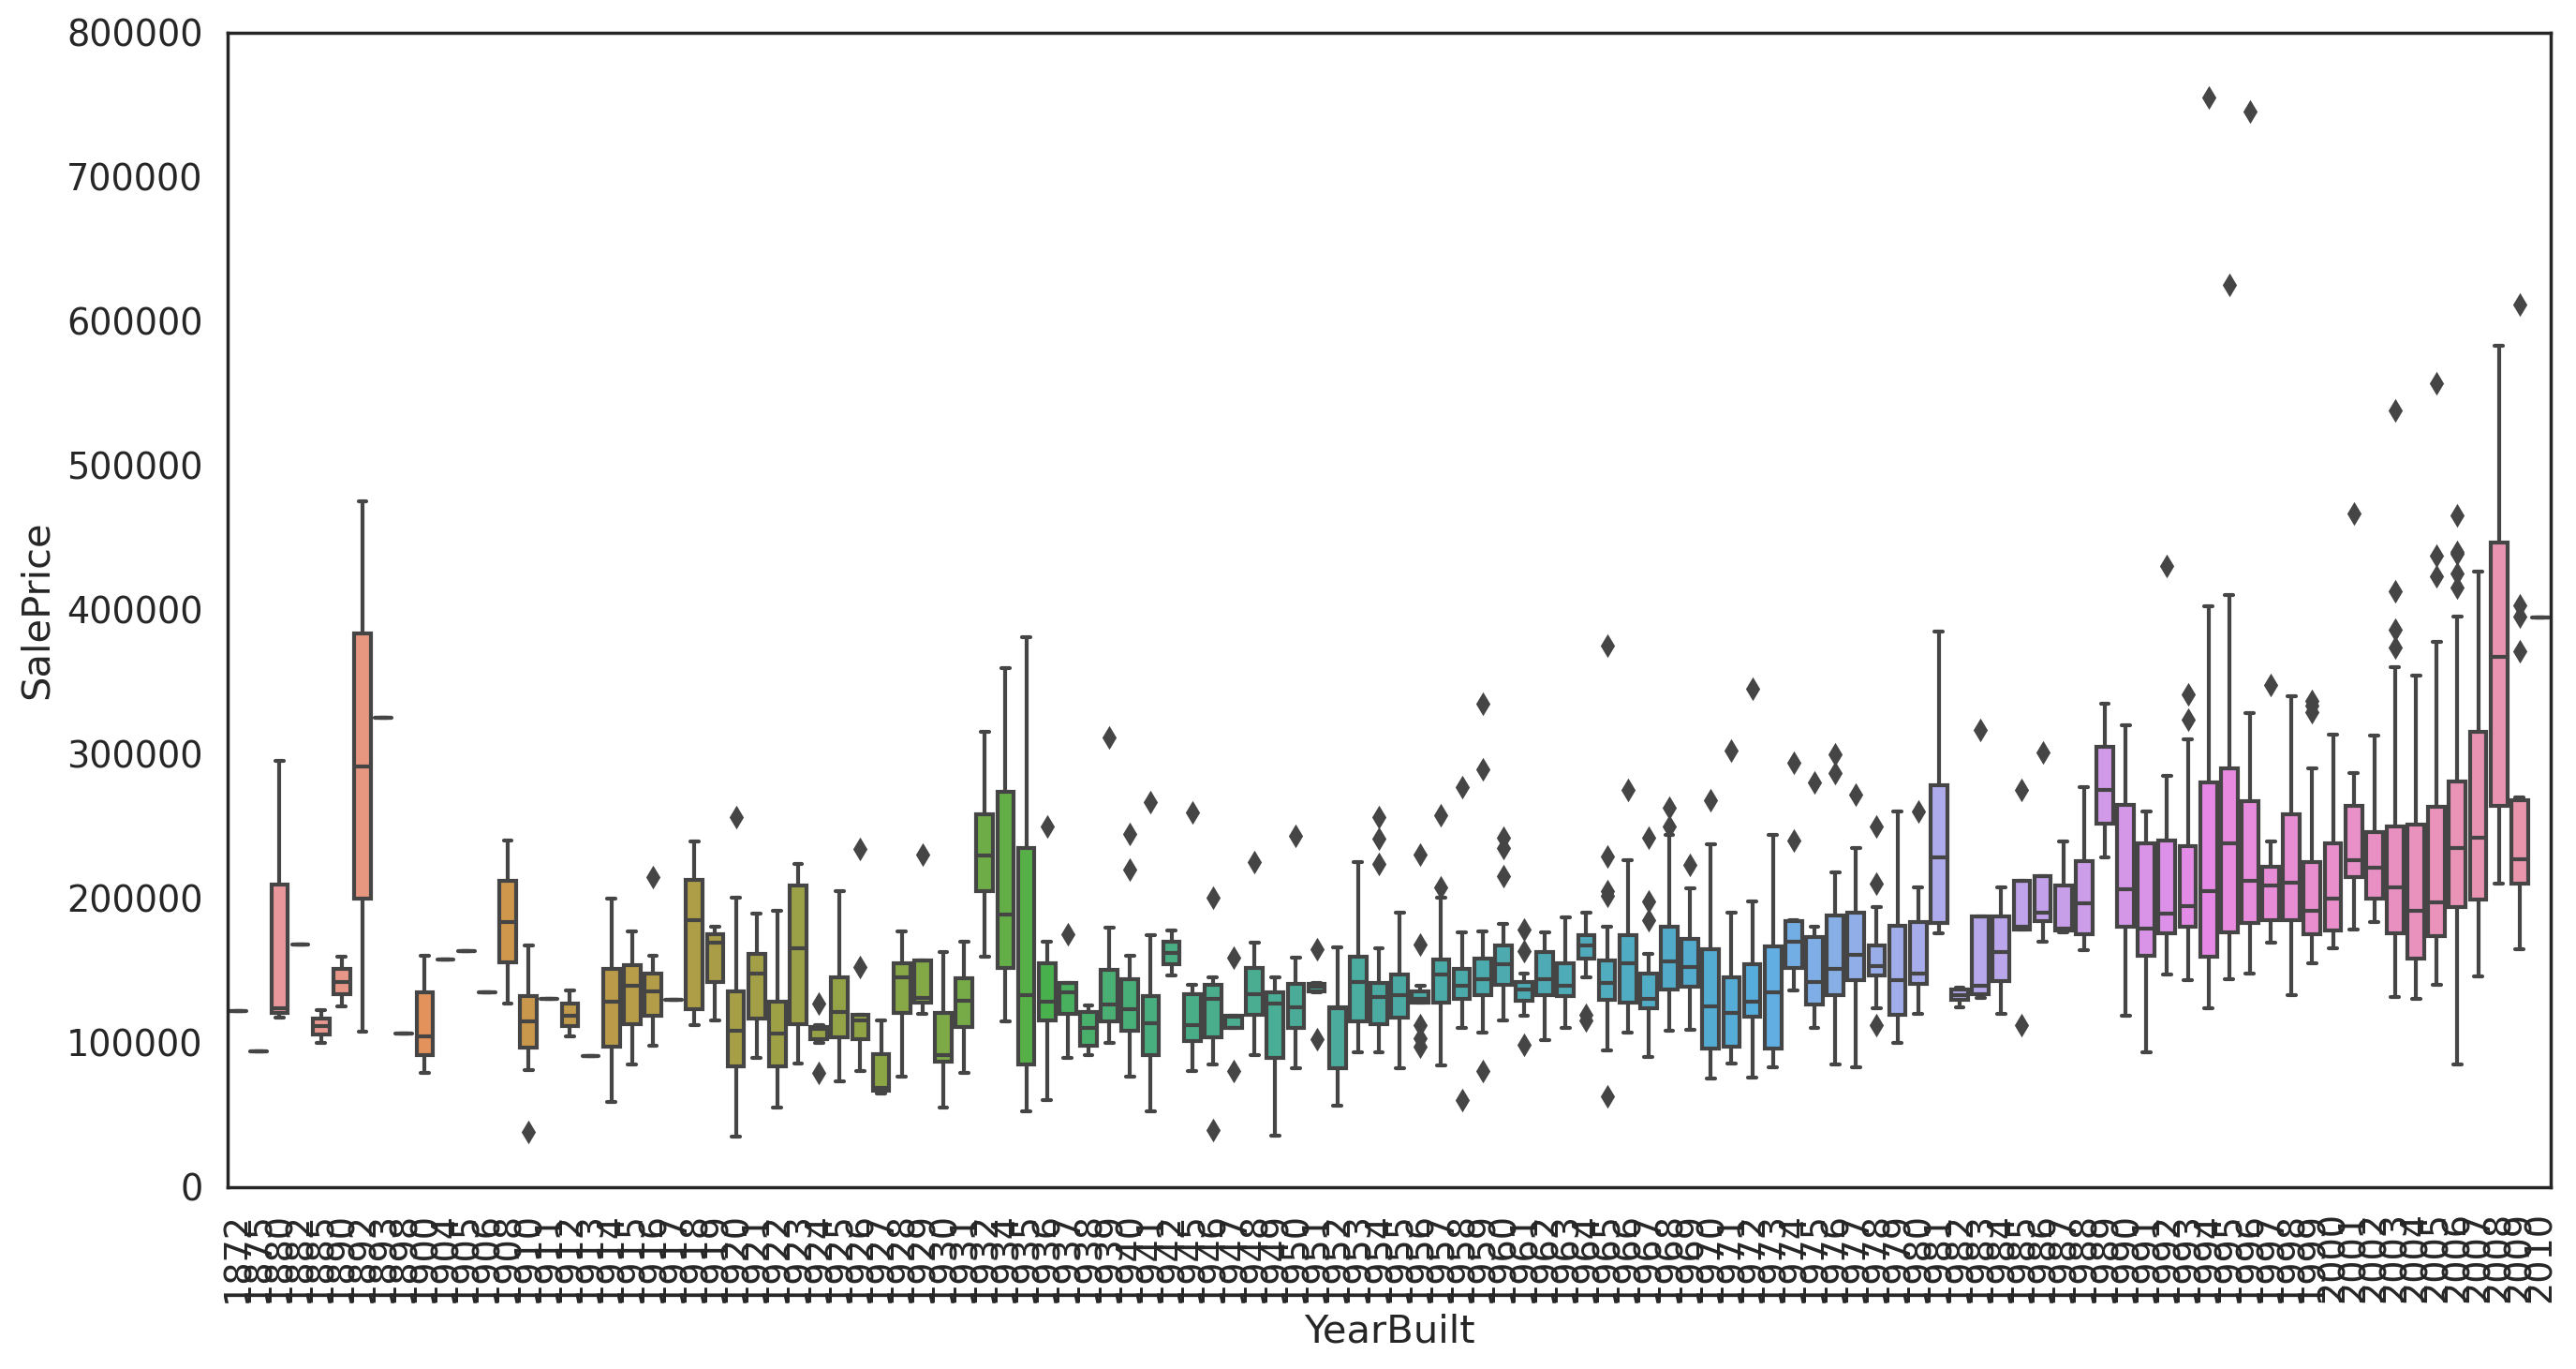

In [29]:
# Total Rooms vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

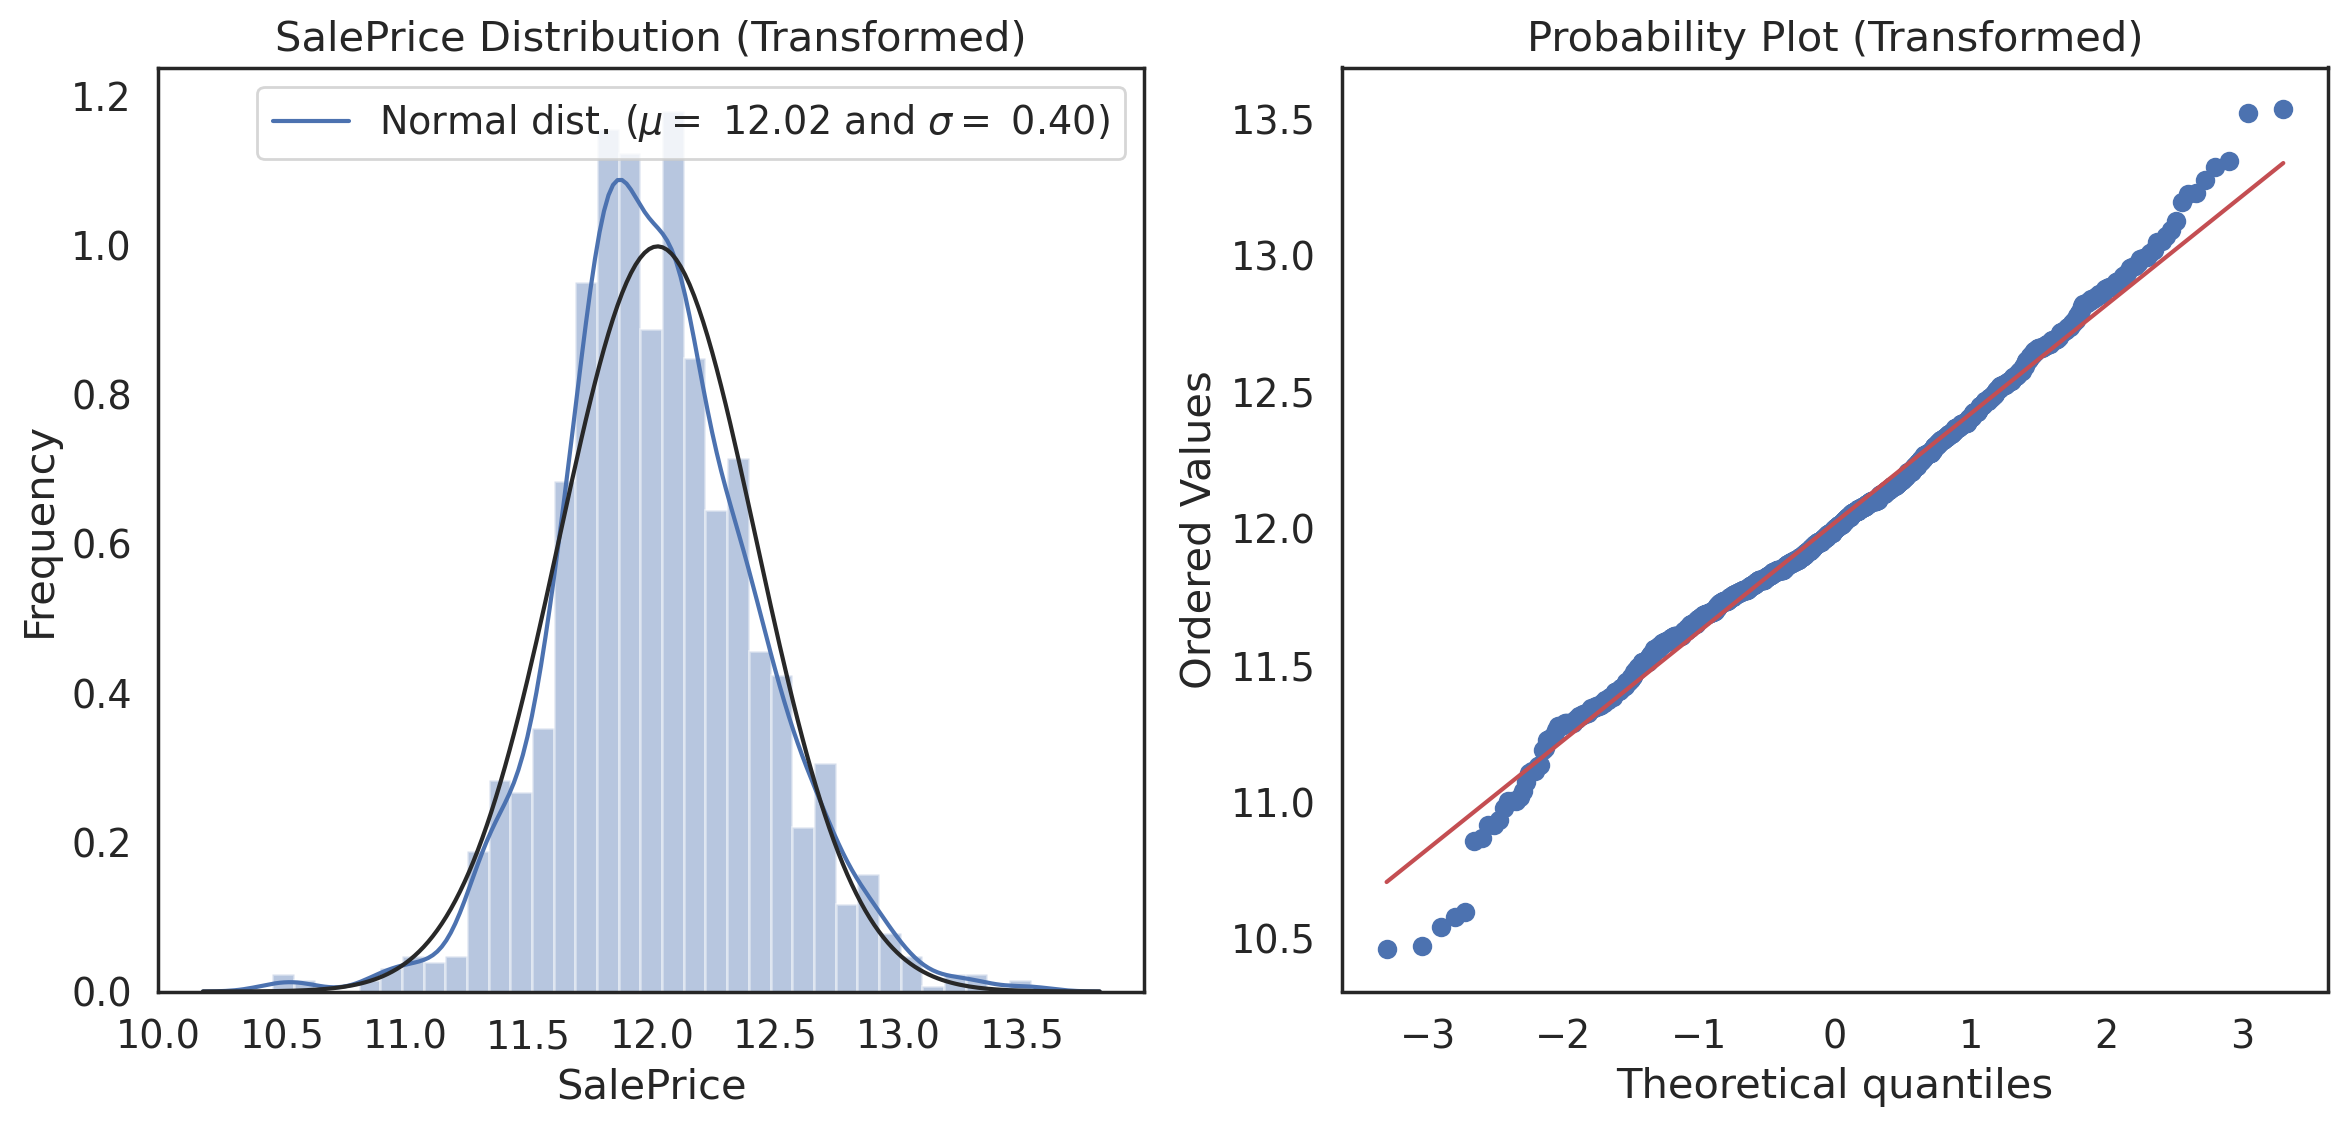

Skewness: 0.130172
Kurtosis: 0.822862


In [30]:
# Apply log(1+x) transformation to 'SalePrice'
train['SalePrice'] = np.log1p(train['SalePrice'])

# Set up the figure with a custom size
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the transformed 'SalePrice' distribution
sns.distplot(train['SalePrice'], fit=norm, ax=ax1)

# Calculate and display the fitted parameters
(mu, sigma) = norm.fit(train['SalePrice'])
ax1.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('SalePrice Distribution (Transformed)')

# Create a probability plot
stats.probplot(train['SalePrice'], plot=ax2)
ax2.set_title('Probability Plot (Transformed)')
plt.show()

# Save the transformed 'SalePrice' values for training
y_train = train.SalePrice.values

# Calculate and print skewness and kurtosis
print(f"Skewness: {train['SalePrice'].skew():.6f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.6f}")

MODEL MAKING

In [31]:
#encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [32]:
#encode categorical variables in test set
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

In [33]:
#fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [34]:
#apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [35]:
#apply log transformation to reduce skewness over .75 by taking log(feature + 1) in test set
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

In [36]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
lr = linear_model.LinearRegression()

In [38]:
model = lr.fit(X_train, y_train)

In [39]:
#make predictions based on model
predictions = model.predict(X_test)

In [40]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.09028279399999684
MSE is: 0.01572791165997056
RMSE is: 0.125410971051063


Text(0.5, 1.0, 'Linear Regression Model')

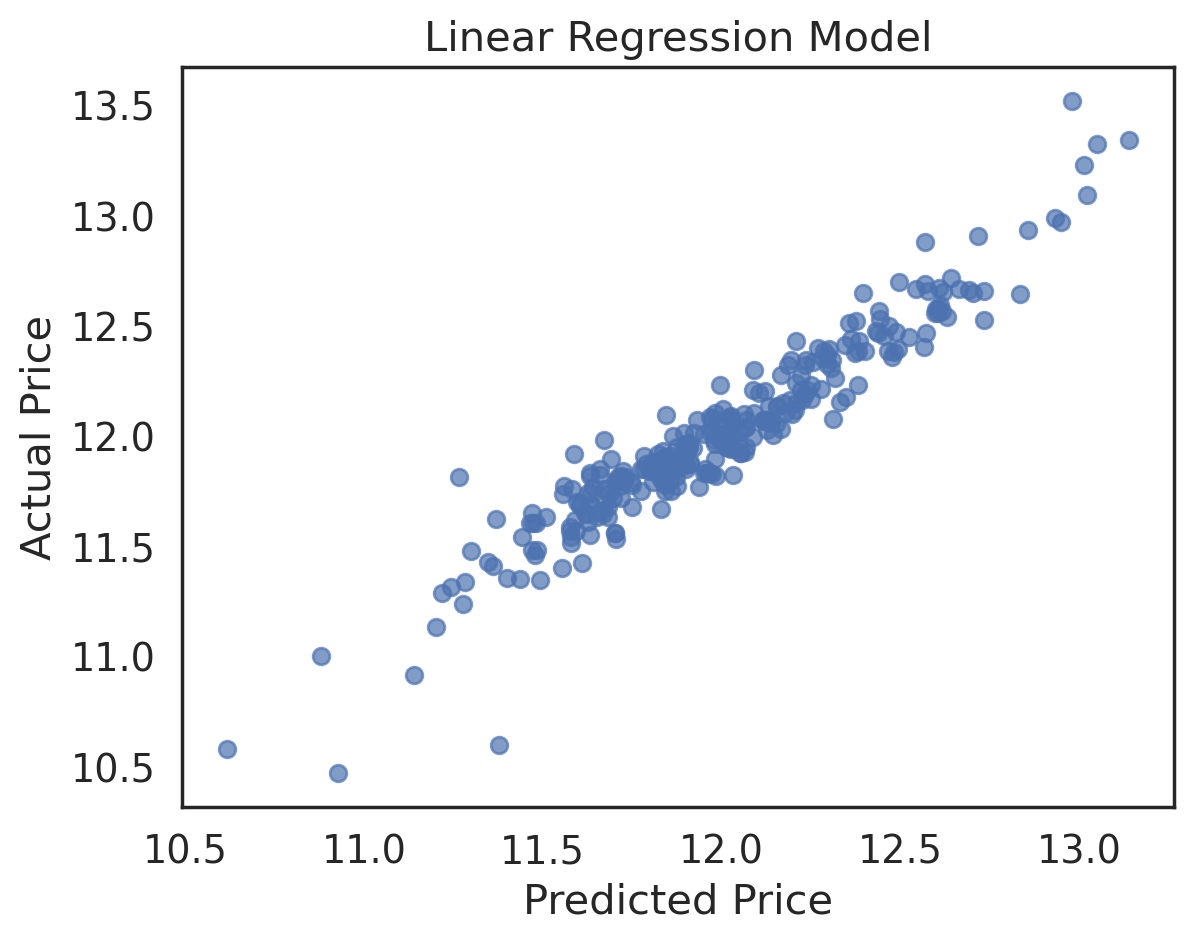

In [41]:
#alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')